# Experiment 2: Investigating retrieval for different number of topics

## Introduction
A strategy to determine the number of topics, the so called elbow method, is generally used. This strategy is based on topic coherence scores. However, topic coherence scores are measures which was developed to try and determine when the topic makes most sense to humans.

The measure we need to use is one for retrieval. We need to investigate the effect of choosing a different number of topics from that of the elbow method, and compare the retrieval results.

## Experiment description
 - Choose a reference email for a search. In our case it will be one from a newsletter.
 - Fix the corpus and train a number of topic models:
   - Refence topic model trained based on the number of topics as per the elbow method.
   - Topic models with number of topics lower than what the elbow method requires.
   - Topic models with number of topics higher than what the elbow method requires.
 - For each topic model, score the emails in the search space with each of the trained models.
 - Using the reference email, retrieve ranked emails and compare their relative positions to each other.
 

In [1]:
import os
import re
import os
import tempfile
import math
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import json
from pprint import pprint

from tqdm import tqdm

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

import plotly.graph_objects as go


################ Function definitions ###############
# A helper function which loads the json email and returns it as a dictionary
def loadMail(filename):
    with open (filename, "r") as inputFile:
        return json.load(inputFile)
################ End Function definitions ###############


########## Code: Loading Dictionaries #########
def build_dictionaries(subdir, pre_pend_filter = "",  bow_docs_pos = None, dictionary_pos = None, texts_pos = None, filenames = None, limit = 10000, paragraphs = False):
    # This technique requires dictionaries to fit in available memory.
    # It is good for experimenting, but not for general purpose use if lots of data will be processed.
    if(bow_docs_pos == None):
        bow_docs_pos = []
        texts_pos = []
        dictionary_pos = Dictionary()      # Dictionary based on Part of Speech tagging
        filenames = []
    bow_docs_common = []
    texts_common = []
    dictionary_common = Dictionary()   # Dictionary based on common words


    print("Building dictionaries\n")
    #print("Files")
    #print(filenames)

    # Build a dictionary of all the emails
    count = 0
    for root, dirs, files in os.walk(subdir):
        for file in files:
            if not re.search(r'^\.',file):     #Filter out common files created by the OS
                filename = os.path.basename(file)
                if pre_pend_filter == "" or re.match(pre_pend_filter, filename, flags=re.IGNORECASE) != None:
                    email_file = os.path.join(root,file)
                    #new_mail.initMail(email_file)
                    # Build a dictionary and BOW from common token documents

                    #for key, value in developer.items():
                        #print(key, ":", value)
                    email_dict = loadMail(email_file)
                    if paragraphs:
                        paragraph_list = email_dict['body_pos_paragraph_tokens']
                        if len(paragraph_list) > 0:
                            for paragraph in paragraph_list:
                                texts_pos.append(paragraph)
                                dictionary_pos.add_documents([paragraph])
                                bow_docs_pos.append(dictionary_pos.doc2bow(paragraph))
                                #print(email_file)
                                filenames.append(email_file)
                                
                    else:
                        texts_common.append(email_dict['body_tokens'])
                        dictionary_common.add_documents([email_dict['body_tokens']])
                        bow_docs_common.append(dictionary_common.doc2bow(email_dict["body_tokens"]))

                        # Build a specialised POS dictionary and BOW
                        if(email_dict["body_pos_tokens"] != None):
                            texts_pos.append(email_dict["body_pos_tokens"])
                            dictionary_pos.add_documents([email_dict["body_pos_tokens"]])
                            bow_docs_pos.append(dictionary_pos.doc2bow(email_dict["body_pos_tokens"]))
                            filenames.append(email_file)

                    if count == limit:
                        break
                    else:
                        count = count + 1
    print("Finished building dictionaries.\n\n")

    print("Number of documents in the BOW corpus: ",len(bow_docs_common))
    print("Number of documents in the POS corpus: ",len(bow_docs_pos))
    
    return bow_docs_common,dictionary_common,texts_common,bow_docs_pos,dictionary_pos,texts_pos,filenames

### Define a helper function to initialise and train the LDA model #####
### The defaults fix some hyperparameters for the LDA model which can be overwritten #####
def build_LDA_model(dictionary, bow_docs, num_topics = 2, 
              chunksize = 2000, 
              passes = 20, 
              iterations = 400, 
              eval_every = None):

    dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token

    model = LdaModel(
        corpus=bow_docs,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every)

    return model

#Define a general helper function to take the trained model and plot a wordcloud of the topics.
def plot_wordcloud(model,filename = ''):
    # Extract the topic words and related frequecies.
    topics = model.show_topics(formatted=False)

    # Define a square mask to print the wordcloud.
    x, y = np.ogrid[:500, :500]
    mask = (x - 250) ** 2 + (y - 250) ** 2 > 250 ** 2
    mask = 255 * mask.astype(int)

    # For each topic, extract the word and frequencies, build a wordcloud and display it.
    for topic_nr,topic in zip(range(0,len(topics)),topics):
        topic_words = dict(topic[1])
        cloud = WordCloud(mask=mask,background_color="white").generate_from_frequencies(topic_words)
        plt.figure()
        plt.imshow(cloud)
        plt.axis("off")
        plt.title("Topic nr : " + str(topic_nr + 1))
        plt.show()
        if filename != '':
            topic_filename = filename + '_topic_' + str(topic_nr + 1) + '.png'
            print('Saving: ',topic_filename)
            cloud.to_file(topic_filename)
            
# Helper function to score topics in a range and retain the models in memory
def score_topics(dictionary, bow_docs, texts, start=1, stop=2, step=1, show_progress = True,
                store_models = False, prefix='', num_topics_list = None):

    scores = []
    if num_topics_list is None:
        num_topics_list = list(range(start,stop))   # Build a list of integers from start to stop
        num_topics_subset = num_topics_list[::step] # Pick the subset with step size
    else:
        num_topics_subset = num_topics_list
        
  
        
    with tqdm(total=len(num_topics_subset)) as pbar:
        for num_topics in num_topics_subset:
            model = build_LDA_model(dictionary, bow_docs, num_topics)   #Build the model
            coherence_model_lda = CoherenceModel(model=model, texts = texts, 
                                                 dictionary = dictionary, 
                                                 coherence='c_v')       # Build the coherence model
            coherence_lda = coherence_model_lda.get_coherence()         # Get the coherence score
            scores.append((num_topics, coherence_lda, model))           # Save the coherece score with the associated number of topics
            #if store_models:
            #    with tempfile.NamedTemporaryFile(mode='w+b', prefix=prefix + '_'+str(num_topics)+'_',
            #                                     dir=tmpdir,delete=False) as tmp:
            #        lda.save(tmp.name)
            pbar.update(1)
    
    if store_models:
        tmpdir = tempfile.mkdtemp(prefix = prefix + '_',dir = '.')     #Create a directory to save the models
        score_pairs = {}
        for score in scores:
            num_topics,score,model = score       #Extract the three elements
            with tempfile.NamedTemporaryFile(mode='w+b', prefix=prefix + '_'+str(num_topics)+'_',
                                             dir=tmpdir,delete=False) as tmp:
                    model.save(tmp.name)
            score_pairs[num_topics] = score
        
        with tempfile.NamedTemporaryFile(mode='w', prefix=prefix + '_scores_', suffix = '.json',
                                         dir=tmpdir,delete=False) as tmp:
            print(score_pairs)
            json.dump(score_pairs,tmp)

    return scores

# Helper function which uses plotly to plot the scores
def plot_topic_scores(scores,reference = 0):
    x = []
    y = []
    min = 1
    max = 0

    # Extract the scores as x,y pairs
    for entry in scores:
        x.append(entry[0])
        y.append(entry[1])
        if entry[1] > max:
            max = entry[1]
        if entry[1] < min:
            min = entry[1];

    no_steps = len(x)
    step_size = x[1] - x[0]
    title = 'No of models: ' + str(no_steps) + ' -- Spacing:' + str(step_size)

    fig = go.Figure(data=go.Scatter(x=x, y=y,name='Candidate topic models'))
    if reference != 0:
        index = x.index(reference)
        value = round(y[index],5)
        marker_name = 'No of topics: ' + str(reference) + '\n -- Score: ' + str(value)
        fig.add_scatter(x=[reference]*1, y=[value], name=marker_name)
    fig.update_layout(
        title={
            'text' : title,
            'y':0.9,
            'x':0.4,
            'xanchor': 'center',
            'yanchor': 'top'},
        xaxis_title="Number of topics",
        yaxis_title="Topic coherence score",
        legend_title="",
        font=dict(family="Arial")
    )
    fig.show()




def vectorise(topic_scores,nr_topics):
    vector = [0] * nr_topics
    
    for score in topic_scores:
        vector[score[0]] = score[1]
    return vector

def dot_product(vector1,vector2):
    dot_product_sum = 0
    vector1_sum = 0
    vector2_sum = 0
    
    for v1,v2 in zip(vector1,vector2):
        dot_product_sum = dot_product_sum + (v1*v2)
        vector1_sum = vector1_sum + v1*v1
        vector2_sum = vector2_sum + v2*v2
        
    vector_product = round(dot_product_sum,20) / round(math.sqrt(vector1_sum) * math.sqrt(vector2_sum),20)
    return (round(vector_product,5))

def cosine_sim(vector1,vector2):
    vector_product = dot_product(vector1,vector2)
    try:
        angle_radians = math.acos(vector_product)
    except:
        print(vector_product)
        if(vector_product > 1.0):
            vector_product = 1.0
            angle_radians = math.acos(vector_product)
    return math.degrees(angle_radians)

def simialarity(score1,score2,nr_topics):
    vector1 = vectorise(score1,nr_topics)
    vector2 = vectorise(score2,nr_topics)
    angle = cosine_sim(vector1,vector2)
    percentage_simialarity = 100 * (90-angle) / 90
    return percentage_simialarity

def extract_model(scored_models, no_topics):
    model = None
    for scored_model in scored_models:
        if scored_model[0] == no_topics:
            model = scored_model
    return model

def store_scored_models(models_list, path, file_prepend):
    for scored_reference in models_list:
        print(scored_reference)
        filename = path + file_prepend + str(scored_reference[0])
        coherence_score = scored_reference[1]
        model = scored_reference[2]
        print(filename)
        model.save(filename)


def load_scored_model(path,file_prepend, no_topics,texts,dictionary):
    filename = path + file_prepend +str(no_topics)
    print('Loading model:',filename)
    stored_model = LdaModel.load(filename)
    print('Scoring model')
    coherence_model_lda = CoherenceModel(model=stored_model, texts = texts, 
                                                 dictionary = dictionary, 
                                                 coherence='c_v')       # Build the coherence model
    coherence_lda = coherence_model_lda.get_coherence()         # Get the coherence score
    print('Model score:', coherence_lda)
    print()
    return (no_topics,coherence_lda,stored_model)


def score_query(filename, model, dictionary):
    # Load the query email and convert it to tokens.
    email = loadMail(query_email_filename)
    
    bow = []
    #Load the email and convert to BOW
    if(email["body_pos_tokens"] != None):
        bow.append(dictionary.doc2bow(email["body_pos_tokens"]))
        score = model[2][bow[0]]
    return score

def score_mails(reference_model, query_email_scores, dictionary, texts, files, ranked = True):

    score_dictionary = {}
    file_mapping = {}
    email_nr = 0
    with tqdm(total=len(texts)) as pbar:
        for tokens,filename in zip(texts,files):
            email_nr = email_nr + 1

            model = reference_model[2]     # Extract the model
            bow = dictionary.doc2bow(tokens)
            document_score = model[bow]    # Score the email

            if len(document_score) == 0:
                sim = 0.0
            else:
                sim = simialarity(query_email_scores,document_score,reference_model[0])  #Calculate simialarity to query email
            #email_simialarity_scores[index].append(sim)   # Store the simialarity in order of scoring
            score_dictionary[email_nr] = sim              # Store similariy in dictionary, with key posisition in scoring
            file_mapping[email_nr] = filename
            pbar.update(1)
 
    if ranked:
        score_dictionary = sorted(score_dictionary.items(),key=lambda x: x[1], reverse = True)
        
    return score_dictionary,file_mapping

def extract_top_results(ranked_emails, file_mapping, top):
    
    unique_ranking = 1
    overall_cnt = 0
    extracted_filenames = {}
    for email in ranked_emails:
        #overall_cnt = overall_cnt + 1
        index = email[0]
        score = email[1]
        if score != 0.0:
            #filename = os.path.basename(file_mapping[index])
            if file_mapping[index] not in extracted_filenames:
                extracted_filenames[file_mapping[index]] = unique_ranking
                unique_ranking = unique_ranking + 1
                if (unique_ranking - 1) == top:
                    break
            #print(filename,score)
    #print(unique_ranking - 1,overall_cnt)
    return(extracted_filenames)

def calculate_correct_hits(results,file_prepend):
    relevant = 0
    non_relevant = 0
    zeros = 0
    for result in results:
        filename = os.path.basename(result)
        if file_prepend in filename:
            relevant = relevant + 1
        else:
            non_relevant = non_relevant + 1
    return relevant,non_relevant

def precision(relevant, non_relevant):
    #print(relevant,non_relevant,relevant+non_relevant)
    precision = relevant / (relevant + non_relevant)
    return precision

def recall(relevant, total_relevant):
    recall = relevant / total_relevant
    return recall



def printStats(relevant, non_relevant, total_relevant, top_results):
    print('Total number of results returned',len(top_results))
    print('Relevant: ',relevant,'Non-relevant: ',non_relevant)
    print('Precision: ',precision(relevant, non_relevant))
    print('Recall : ', recall(relevant,total_relevant))
    print()

def plot_pr_metrics(top_n, precision_list, recall_list, title, reference = 0):
    fig = go.Figure(data=go.Scatter(x=top_n, y=precision_list,name='Precision'))
    fig.add_scatter(x=top_n, y=recall_list,name='Recall')
    fig.update_layout(
        title={
            'text' : title,
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        xaxis_title="Top results",
        yaxis_title="",
        legend_title="Score Type",
        font=dict(
            family="Arial"
            )
    )
    #fig.add_scatter(x=[reference]*100, y=np.linspace(min,max,100), name='Reference point')
    fig.show()

def generate_metrics(ranked_emails, file_mapping, top_n):
    precision_list = []
    recall_list = []
    for top in top_n:
        top_results = extract_top_results(ranked_emails, file_mapping, top)
        relevant,non_relevant = calculate_correct_hits(top_results,'Multex')
        precision_list.append(precision(relevant, non_relevant))
        recall_list.append(recall(relevant,total_relevant))
    return(precision_list,recall_list)


def plot_multiple_metrics(top_n, name_list, metric_list, title, legend_title):
    fig = go.Figure()
    for name,metric in zip(name_list,metric_list):
        fig.add_scatter(x=top_n, y=metric, name=name)
    
    fig.update_layout(
    title={
        'text' : title,
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Top results",
    yaxis_title="",
    legend_title=legend_title,
    font=dict(
        family="Arial"
        )
    )
    fig.show()


In [79]:
def store_scored_models_data(models_list, path, file_prepend):
    
    data_file =  path + file_prepend + '_data.json'
    model_dictionary = {}
    #filenames = []
    #scores = []

    for scored_reference in models_list:
        #print(scored_reference)
        filename = path + file_prepend + str(scored_reference[0])
        coherence_score = scored_reference[1]
        model_dictionary[filename] = coherence_score
        #model = scored_reference[2]
        #print(filename)
        #model.save(filename)
    with open(data_file, "w") as out_file:
        json.dump(model_dictionary, out_file)
    #print(json.dumps(model_dictionary))
    
    
def load_scored_models_data(path, file_prepend):
    
    data_file =  path + file_prepend + '_data.json'
    with open(data_file) as infile:
        try:
            model_dictionary = json.load(infile)
        except:
            model_dictionary = None

    return model_dictionary

    
#store_scored_models_data(reference_models_scored, 'stored_models_experiment2/','New_reference_')

model_dictionary = load_scored_models_data('stored_models_experiment2/','New_reference_')
model_dictionary




{'stored_models_experiment2/New_reference_20': 0.36879304745381386,
 'stored_models_experiment2/New_reference_936': 0.4470178782498917,
 'stored_models_experiment2/New_reference_946': 0.44515226574426003,
 'stored_models_experiment2/New_reference_956': 0.43920143658145283,
 'stored_models_experiment2/New_reference_966': 0.44730853429283257,
 'stored_models_experiment2/New_reference_972': 0.4408969696597743,
 'stored_models_experiment2/New_reference_973': 0.44943424494818107,
 'stored_models_experiment2/New_reference_974': 0.4511927852626827,
 'stored_models_experiment2/New_reference_975': 0.4410047052419254,
 'stored_models_experiment2/New_reference_976': 0.4554753892867113,
 'stored_models_experiment2/New_reference_977': 0.4418285149046911,
 'stored_models_experiment2/New_reference_978': 0.44601134765090494,
 'stored_models_experiment2/New_reference_979': 0.4425833391765343,
 'stored_models_experiment2/New_reference_980': 0.4501320393553907,
 'stored_models_experiment2/New_reference_9

### Build the reference bag-of-words

For the purposes of the experiment, it will suffice to build a bag-of-words of only allen-p's emails. Any subdirectory can be chosen.

In [3]:
########## Initialisation Section ##########
# Set the location of the directory used for processing
maildir_path = os.path.join('..','..','data', 'processed', 'experimental_data')
subdir = os.path.join(maildir_path,'allen-p') 
#subdir = os.path.join(maildir_path,'allen-p','_sent_mail') 

multex_subdir = os.path.join('..','..','data', 'processed', 'Multex')



########## End Initialisation Section ##########


# Build the dictionaries
print('Building normal dictionaries')
_,_,_,email_bow,email_dictionary,email_texts,email_files = build_dictionaries(multex_subdir,pre_pend_filter = "", paragraphs=False)
_,_,_,email_bow,email_dictionary,email_texts,email_files = build_dictionaries(subdir,pre_pend_filter = "Full_", paragraphs=False, bow_docs_pos = email_bow, dictionary_pos = email_dictionary, texts_pos = email_texts, filenames = email_files)
#print(email_files)




Building normal dictionaries
Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  149
Number of documents in the POS corpus:  149
Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  3034
Number of documents in the POS corpus:  3183


In [2]:
########## Initialisation Section ##########
# Set the location of the directory used for processing
maildir_path = os.path.join('..','..','data', 'processed', 'experimental_data')
subdir = os.path.join(maildir_path,'allen-p') 
#subdir = os.path.join(maildir_path,'allen-p','_sent_mail') 


########## End Initialisation Section ##########


# Build the dictionaries
bow_docs_common,dictionary_common,texts_common,bow_docs_pos,dictionary_pos,texts_pos,files = build_dictionaries(subdir,pre_pend_filter = "Full_")



Building dictionaries

Finished building dictionaries.


Number of documents in the BOW corpus:  3034
Number of documents in the POS corpus:  3034


### Perform coarse search

A course search is perfomed to determine a rough estimate of the elbow point within the step size.

100%|████████████████████████████████████████| 20/20 [1:39:43<00:00, 299.17s/it]


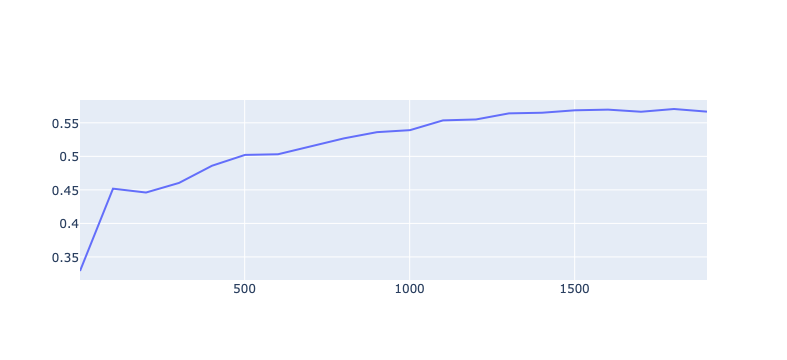

In [3]:
pos_scores_coarse = score_topics(dictionary_pos, bow_docs_pos, texts_pos, start = 1, step = 100, stop = 2000)
    
plot_topic_scores(pos_scores_coarse)        

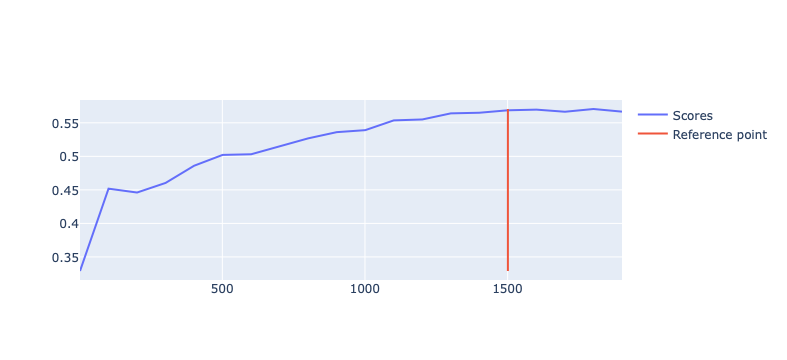

In [4]:
plot_topic_scores(pos_scores_coarse,reference=1501)

### Perform medium search

Based on the above plot, a medium granualarity search is conducted around the chosen point.

100%|████████████████████████████████████████| 10/10 [1:30:09<00:00, 540.98s/it]


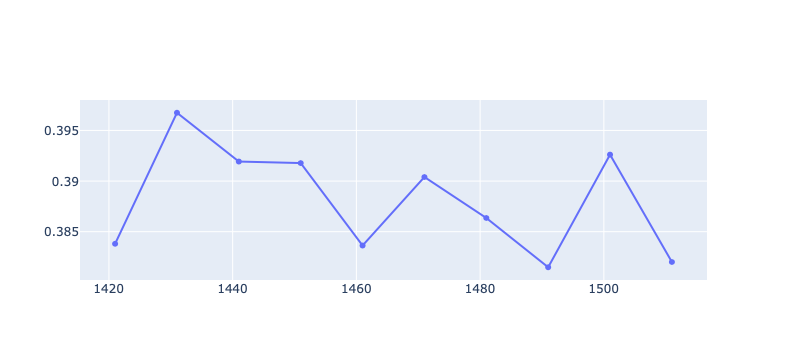

In [6]:
pos_scores_medium = score_topics(dictionary_common, bow_docs_common, texts_common, start = 1421, step = 10, stop = 1521)
    
plot_topic_scores(pos_scores_medium)        

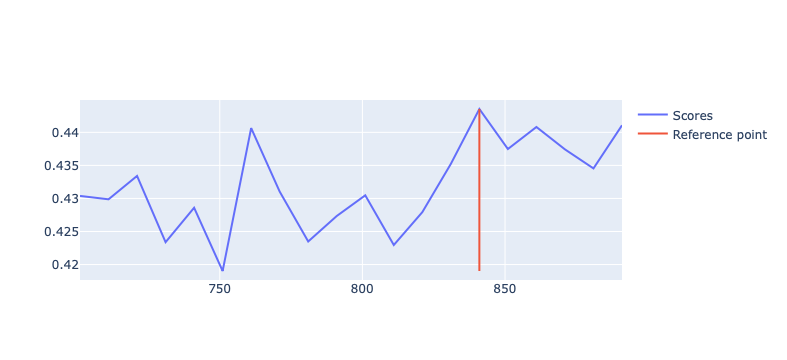

In [27]:
plot_topic_scores(pos_scores_medium,reference=841)

### Perform a fine search

Based on the above plot, a fine granualarity search is conducted around the chosen point.

100%|████████████████████████████████████████| 20/20 [2:43:12<00:00, 489.60s/it]


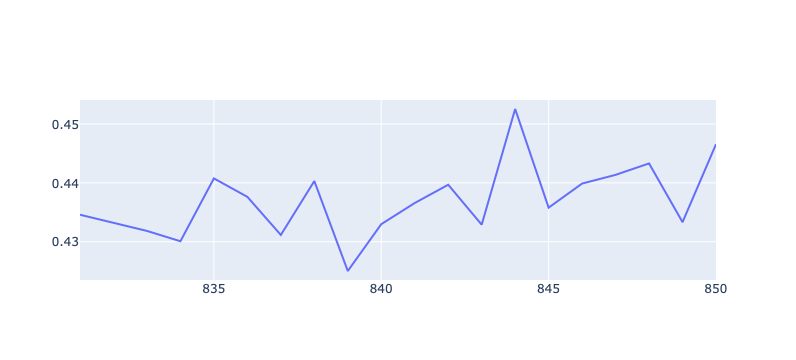

In [25]:
pos_scores_fine = score_topics(dictionary_common, bow_docs_common, texts_common, start = 831, step = 1, stop = 851)
    
plot_topic_scores(pos_scores_fine)        

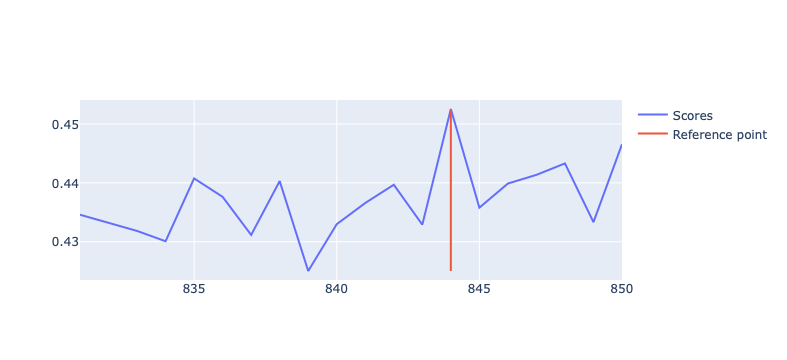

In [26]:
plot_topic_scores(pos_scores_fine,reference=844)

### Train the models

With the reference for the elbow now determined, we train a number of models around the reference. Allow for one more and one less, i.e. very close. Then two further off, and then is way further off. A total of 7 models are therefore trained.

In [4]:
# Load the model from experiment 3 as this is now the final reference model.

no_topics_email = 976
email_model = load_scored_model('stored_models_experiment3/','full_email_', no_topics_email, email_texts, email_dictionary)    
print(email_model)




Loading model: stored_models_experiment3/full_email_976
Scoring model
Model score: 0.4554753892867113

(976, 0.4554753892867113, <gensim.models.ldamodel.LdaModel object at 0x11c3689d0>)


In [9]:
reference_nr_topics = no_topics_email
intervals = [1,2,3,4,10,20,30,40]

# Build a list of number of topics, starting with reference, ref+-1, ref+-2 etc.
num_topics_list_lower = [] 
num_topics_list_upper = [] 
for interval in intervals:
    num_topics_list_upper.append(reference_nr_topics + interval)
    num_topics_list_lower.append(reference_nr_topics - interval)
num_topics_list_upper.sort()
num_topics_list_lower.sort()
num_topics_list_lower.insert(0,20)
#print(num_topics_list_lower,reference_nr_topics,num_topics_list_upper)
# number of topics list is now sorted, with the reference no topics in the middel

#reference_nr_topics_index = math.ceil(len(num_topics_list) / 2)

# Now train all the models with ref_num_topics.
reference_models_scored_lower = score_topics(email_dictionary, email_bow, email_texts,num_topics_list = num_topics_list_lower)
reference_models_scored_upper = score_topics(email_dictionary, email_bow, email_texts,num_topics_list = num_topics_list_upper)

reference_models_scored = reference_models_scored_lower + [email_model] + reference_models_scored_upper

100%|██████████████████████████████████████████| 8/8 [1:32:55<00:00, 696.98s/it]


In [11]:

#reference_models_scored.insert(0,low_topic_model[0])
reference_models_scored
#store_scored_models(reference_models_scored, 'stored_models_experiment2/','New_reference_')

(20, 0.36879304745381386, <gensim.models.ldamodel.LdaModel object at 0x12190c0a0>)
stored_models_experiment2/New_reference_20
(936, 0.4470178782498917, <gensim.models.ldamodel.LdaModel object at 0x1084bbac0>)
stored_models_experiment2/New_reference_936
(946, 0.44515226574426003, <gensim.models.ldamodel.LdaModel object at 0x12171bfa0>)
stored_models_experiment2/New_reference_946
(956, 0.43920143658145283, <gensim.models.ldamodel.LdaModel object at 0x1282338e0>)
stored_models_experiment2/New_reference_956
(966, 0.44730853429283257, <gensim.models.ldamodel.LdaModel object at 0x12205cfa0>)
stored_models_experiment2/New_reference_966
(972, 0.4408969696597743, <gensim.models.ldamodel.LdaModel object at 0x129556fa0>)
stored_models_experiment2/New_reference_972
(973, 0.44943424494818107, <gensim.models.ldamodel.LdaModel object at 0x12a5f6f10>)
stored_models_experiment2/New_reference_973
(974, 0.4511927852626827, <gensim.models.ldamodel.LdaModel object at 0x12b257f10>)
stored_models_experiment2

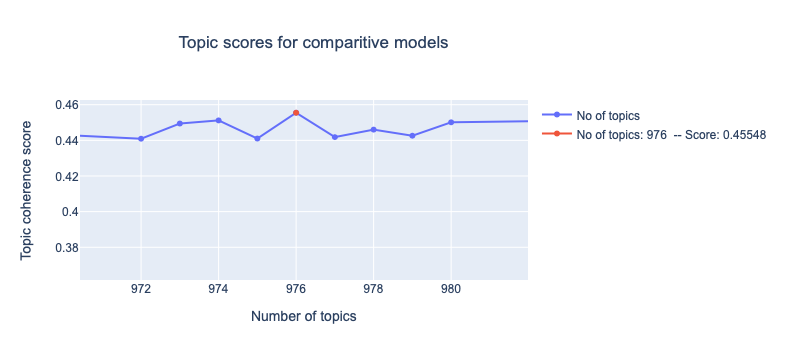

In [123]:
# Helper function which uses plotly to plot the scores
def plot_topic_scores_special(scores,reference = 0):
    x = []
    y = []
    min = 1
    max = 0

    # Extract the scores as x,y pairs
    for entry in scores:
        x.append(entry[0])
        y.append(entry[1])
        if entry[1] > max:
            max = entry[1]
        if entry[1] < min:
            min = entry[1];

    no_steps = len(x)
    step_size = x[1] - x[0]
    title = 'Topic scores for comparitive models'

    fig = go.Figure(data=go.Scatter(x=x, y=y,name='No of topics'))
    if reference != 0:
        index = x.index(reference)
        value = round(y[index],5)
        marker_name = 'No of topics: ' + str(reference) + '\n -- Score: ' + str(value)
        fig.add_scatter(x=[reference]*1, y=[value], name=marker_name)
    fig.update_layout(
        title={
            'text' : title,
            'y':0.9,
            'x':0.4,
            'xanchor': 'center',
            'yanchor': 'top'},
        xaxis_title="Number of topics",
        yaxis_title="Topic coherence score",
        legend_title="",
        font=dict(family="Arial")
    )
    fig.show()
    
plot_topic_scores_special(reference_models_scored,reference = 976)

In [16]:
# Select a query email and score it.

# Build a list of 10 query email filenames
query_filenames = []
reference_query_scores = []
for filenumber in range(1,11):
    query_filenames.append(os.path.join(multex_subdir,'Multex_' + str(filenumber) + '.json'))


#Load and score the ten emails
for query_email_filename in query_filenames:
    model_scores = []
    for model in reference_models_scored:
        #print(model)
        reference_query_score = score_query(query_email_filename, model, email_dictionary)
        model_scores.append(reference_query_score)
    reference_query_scores.append(model_scores)


#email_query_score = email_query_scores[0]
#par_query_score = par_query_scores[0]



In [43]:
# Extract one query for all the models
email_query_scores = reference_query_scores[0]

def score_query(email_query_scores, reference_models_scored, email_dictionary ,email_texts, email_files):
    ranked_email_list = []
    file_mapping_list = []
    for email_query_score,model in zip(email_query_scores,reference_models_scored):
        ranked_emails,file_mapping  = score_mails(model, email_query_score, email_dictionary, email_texts, email_files)
        ranked_email_list.append(ranked_emails)
        file_mapping_list.append(file_mapping)
        
    return(ranked_email_list,file_mapping_list)


#ranked_email_list,file_mapping_list = score_query(email_query_scores, reference_models_scored, email_dictionary ,email_texts, email_files)



In [44]:
def rank_query_collection(reference_query_scores,reference_models_scored,email_dictionary ,email_texts, email_files):
    ranked_queries = []
    ranked_file_mapping_lists = []

    count = 1

    for email_query_scores in reference_query_scores:
        print('Working on ' + str(count))
        count = count + 1
        ranked_email_list,file_mapping_list = score_query(email_query_scores, reference_models_scored, email_dictionary ,email_texts, email_files)
        ranked_queries.append(ranked_email_list)
        ranked_file_mapping_lists.append(file_mapping_list)
    return ranked_queries,ranked_file_mapping_lists

ranked_queries,ranked_file_mapping_lists = rank_query_collection(reference_query_scores,reference_models_scored,email_dictionary ,email_texts, email_files)

Working on 1


100%|██████████████████████████████████████| 3183/3183 [00:19<00:00, 161.99it/s]


Working on 2


100%|██████████████████████████████████████| 3183/3183 [00:23<00:00, 136.43it/s]


Working on 3


100%|██████████████████████████████████████| 3183/3183 [00:27<00:00, 116.44it/s]


Working on 4


100%|██████████████████████████████████████| 3183/3183 [00:19<00:00, 159.67it/s]


Working on 5


100%|██████████████████████████████████████| 3183/3183 [00:17<00:00, 182.10it/s]


Working on 6


100%|██████████████████████████████████████| 3183/3183 [00:17<00:00, 182.09it/s]


Working on 7


100%|██████████████████████████████████████| 3183/3183 [00:20<00:00, 156.44it/s]


Working on 8


100%|██████████████████████████████████████| 3183/3183 [00:20<00:00, 157.68it/s]


Working on 9


100%|██████████████████████████████████████| 3183/3183 [00:21<00:00, 145.28it/s]


Working on 10


100%|██████████████████████████████████████| 3183/3183 [00:25<00:00, 123.55it/s]


In [46]:
total_relevant = 149
top_n = [50,5000]

ranked_email_list = ranked_queries[0]
file_mapping_list = ranked_file_mapping_lists[0]

model_nr = 9

ranked_emails = ranked_email_list[model_nr]
file_mapping = file_mapping_list[model_nr]
print('Model: Email ---- Document definition: Email')
print('--------------------------------------------')
for top in top_n:
    print('Top: ',top)
    top_results = extract_top_results(ranked_emails, file_mapping, top)
    relevant,non_relevant = calculate_correct_hits(top_results,'Multex')
    printStats(relevant, non_relevant, total_relevant, top_results)


    
model_nr = 0

ranked_emails = ranked_email_list[model_nr]
file_mapping = file_mapping_list[model_nr]
print('Model: Email ---- Document definition: Email')
print('--------------------------------------------')
for top in top_n:
    print('Top: ',top)
    top_results = extract_top_results(ranked_emails, file_mapping, top)
    relevant,non_relevant = calculate_correct_hits(top_results,'Multex')
    printStats(relevant, non_relevant, total_relevant, top_results)

model_nr = 17

ranked_emails = ranked_email_list[model_nr]
file_mapping = file_mapping_list[model_nr]
print('Model: Email ---- Document definition: Email')
print('--------------------------------------------')
for top in top_n:
    print('Top: ',top)
    top_results = extract_top_results(ranked_emails, file_mapping, top)
    relevant,non_relevant = calculate_correct_hits(top_results,'Multex')
    printStats(relevant, non_relevant, total_relevant, top_results)




Model: Email ---- Document definition: Email
--------------------------------------------
Top:  50
Total number of results returned 50
Relevant:  42 Non-relevant:  8
Precision:  0.84
Recall :  0.28187919463087246

Top:  5000
Total number of results returned 112
Relevant:  99 Non-relevant:  13
Precision:  0.8839285714285714
Recall :  0.6644295302013423

Model: Email ---- Document definition: Email
--------------------------------------------
Top:  50
Total number of results returned 50
Relevant:  50 Non-relevant:  0
Precision:  1.0
Recall :  0.33557046979865773

Top:  5000
Total number of results returned 680
Relevant:  149 Non-relevant:  531
Precision:  0.21911764705882353
Recall :  1.0

Model: Email ---- Document definition: Email
--------------------------------------------
Top:  50
Total number of results returned 50
Relevant:  50 Non-relevant:  0
Precision:  1.0
Recall :  0.33557046979865773

Top:  5000
Total number of results returned 129
Relevant:  117 Non-relevant:  12
Precision

In [66]:
from operator import add

top_n = [x*10 for x in range(1, 50)]
topic_numbers = num_topics_list_lower + [reference_nr_topics] + num_topics_list_upper
no_samples = len(ranked_queries)

def sum_metrics(list1,list2):
    sum = list( map(add, list1, list2) )
    return sum

def init_pr_dictionaries(topic_numbers, list_size):
    precision_dictionary = {}
    recall_dictionary = {}

    for topic_no in topic_numbers:
        precision_dictionary[topic_no] = [0] * list_size
        recall_dictionary[topic_no] = [0] * list_size

    return precision_dictionary,recall_dictionary

def calculate_pr_sums(ranked_queries,ranked_file_mapping_lists,topic_numbers,top_n):
    list_size = len(top_n)
    precision_dictionary,recall_dictionary = init_pr_dictionaries(topic_numbers, list_size)
    
    count = 1
    for ranked_email_list,file_mapping_list in zip(ranked_queries,ranked_file_mapping_lists):
        print('Calculating precision and recall on ',str(count))
        count = count + 1
        for model_nr,topic_no in zip(range(0,18),topic_numbers):
            # For the current model, calculate the precision and recall
            ranked_emails = ranked_email_list[model_nr]
            file_mapping = file_mapping_list[model_nr]
            precision_list,recall_list = generate_metrics(ranked_emails, file_mapping, top_n)
            # Extract the last sums for this particalur model
            current_precision_list = precision_dictionary[topic_no]
            current_recall_list = recall_dictionary[topic_no]
            # Add the current and newly calculated values
            current_precision_list = sum_metrics(current_precision_list,precision_list)
            current_recall_list = sum_metrics(current_recall_list,recall_list)
            # Store the sums
            precision_dictionary[topic_no] = current_precision_list
            recall_dictionary[topic_no] = current_recall_list
        
    return precision_dictionary,recall_dictionary

def calculate_pr_avgs(precision_dictionary, recall_dictionary, topic_numbers, no_samples):
    for topic_no in topic_numbers:
        print('Calculating average for ',str(topic_no))
        precision_avg = precision_dictionary[topic_no]
        recall_avg = recall_dictionary[topic_no]
        
        precision_avg = [number / no_samples for number in precision_avg]
        recall_avg = [number / no_samples for number in recall_avg]
        
        precision_dictionary[topic_no] = precision_avg
        recall_dictionary[topic_no] = recall_avg
        
    return precision_dictionary,recall_dictionary




In [67]:
precision_dictionary,recall_dictionary = calculate_pr_sums(ranked_queries,ranked_file_mapping_lists,topic_numbers,top_n)
precision_dictionary,recall_dictionary = calculate_pr_avgs(precision_dictionary, recall_dictionary, topic_numbers, no_samples)

Calculating precision and recall on  1
Calculating precision and recall on  2
Calculating precision and recall on  3
Calculating precision and recall on  4
Calculating precision and recall on  5
Calculating precision and recall on  6
Calculating precision and recall on  7
Calculating precision and recall on  8
Calculating precision and recall on  9
Calculating precision and recall on  10
Calculating average for  20
Calculating average for  936
Calculating average for  946
Calculating average for  956
Calculating average for  966
Calculating average for  972
Calculating average for  973
Calculating average for  974
Calculating average for  975
Calculating average for  976
Calculating average for  977
Calculating average for  978
Calculating average for  979
Calculating average for  980
Calculating average for  986
Calculating average for  996
Calculating average for  1006
Calculating average for  1016


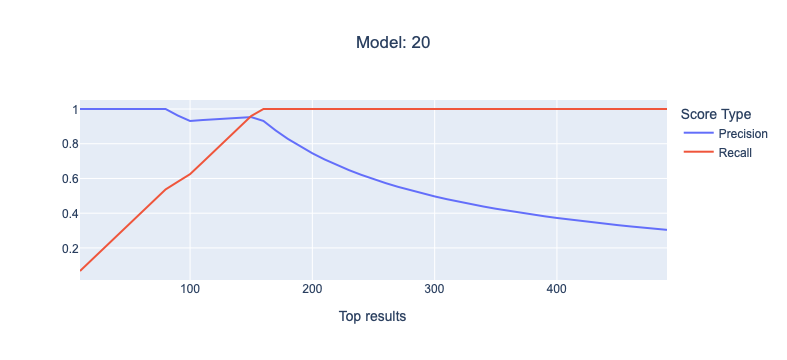

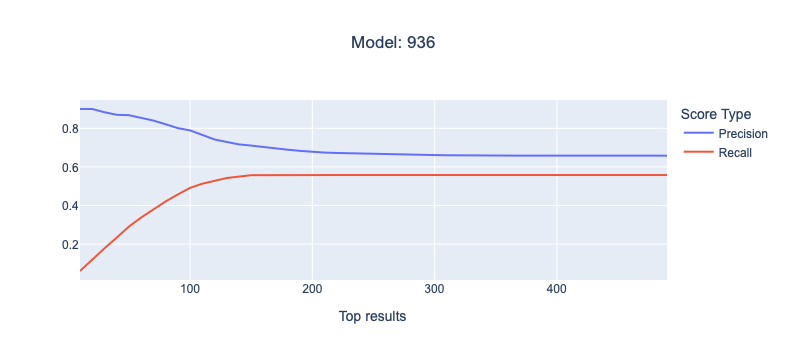

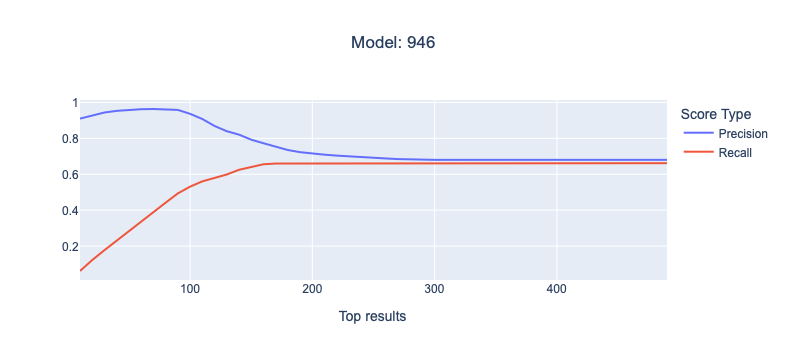

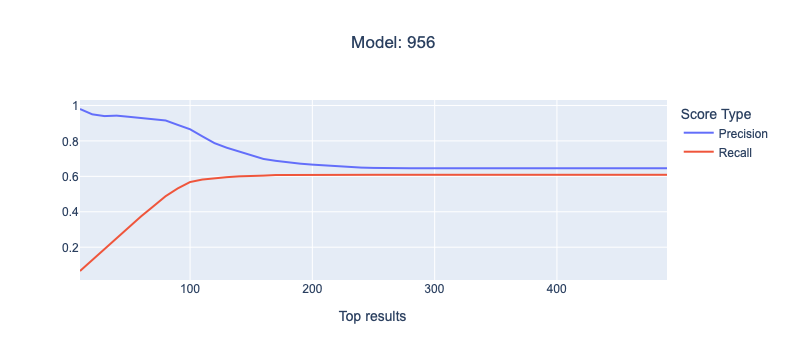

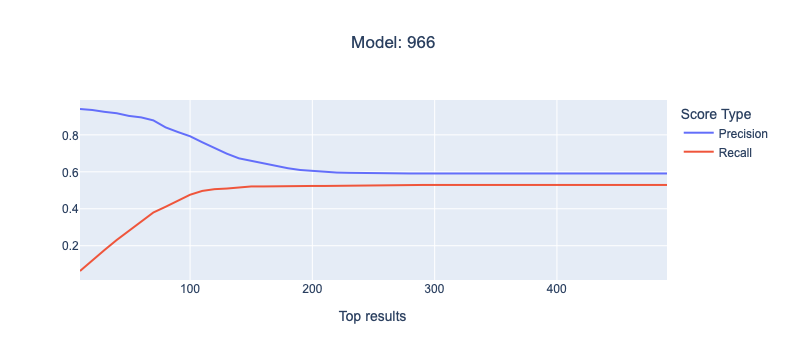

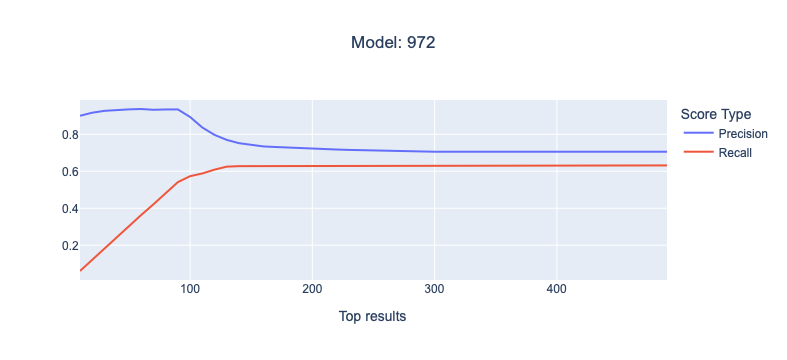

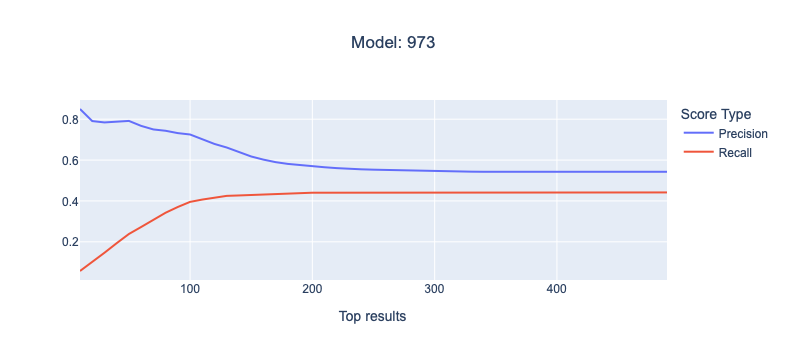

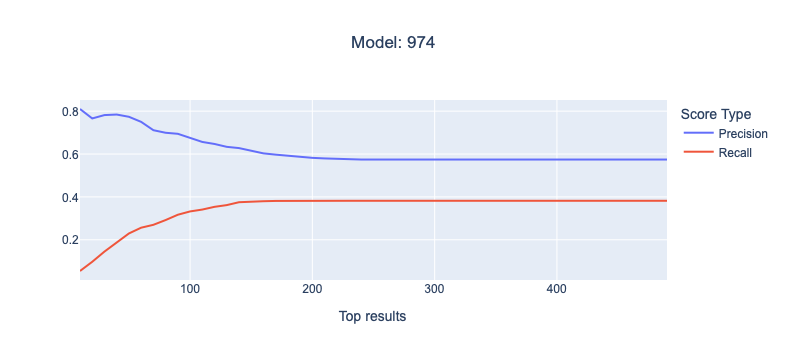

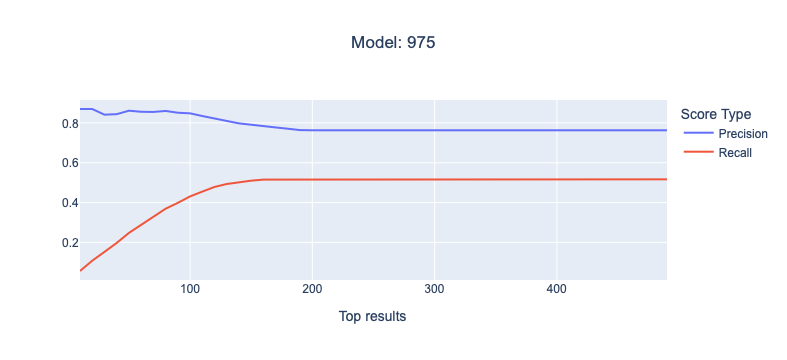

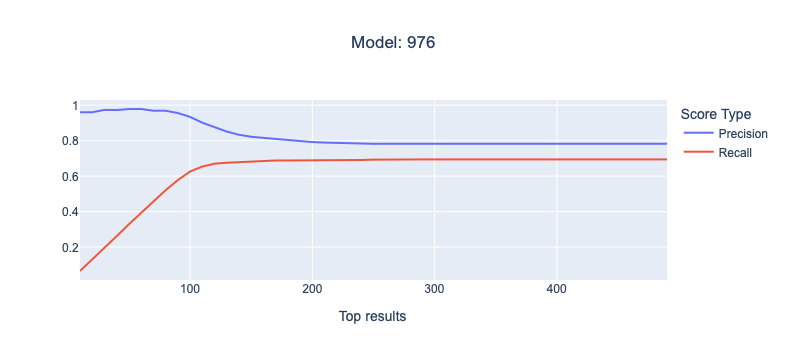

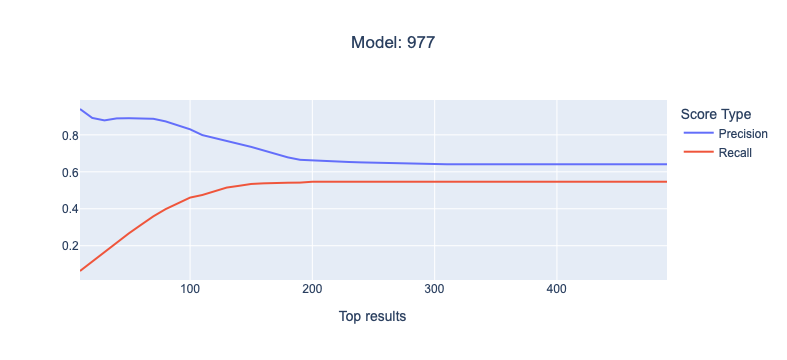

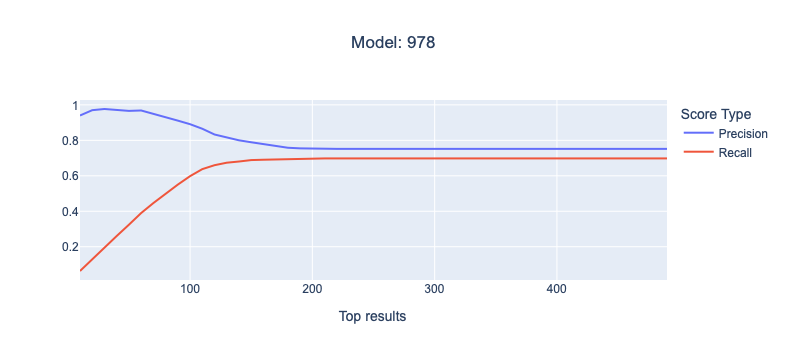

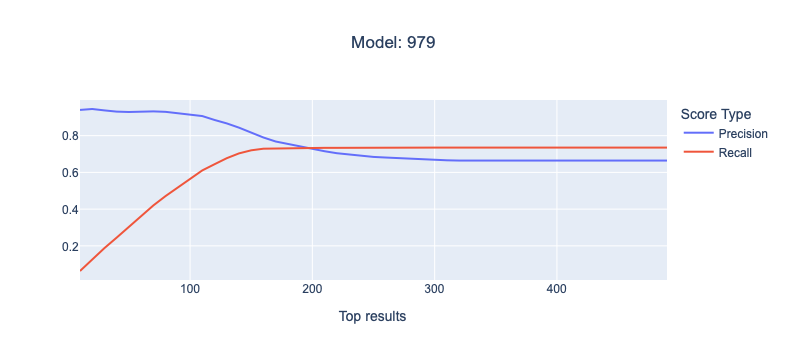

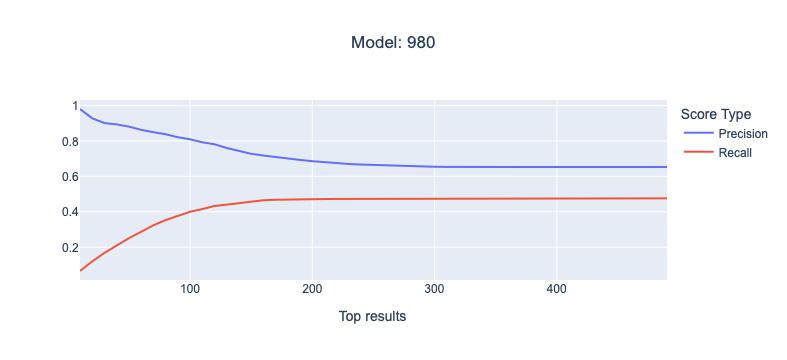

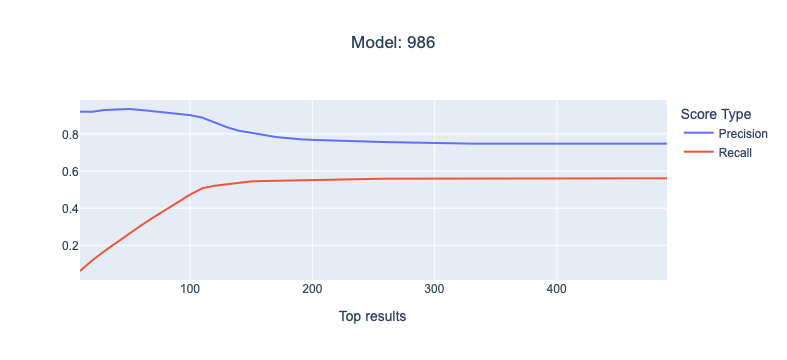

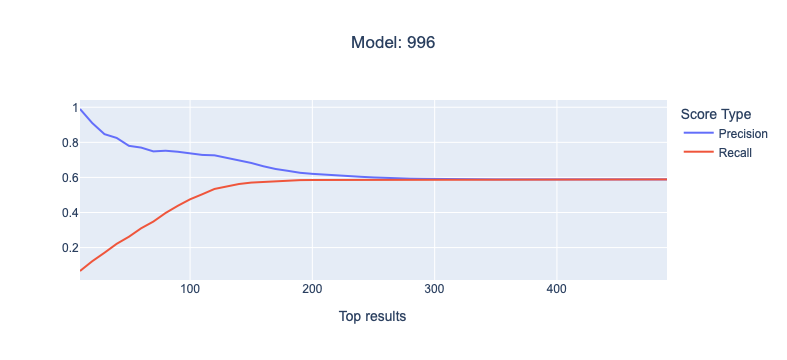

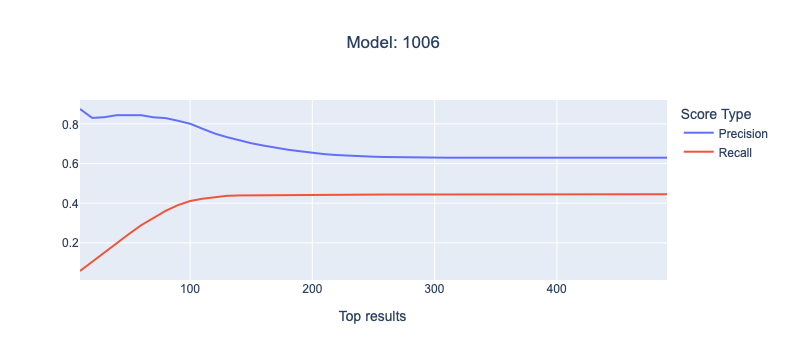

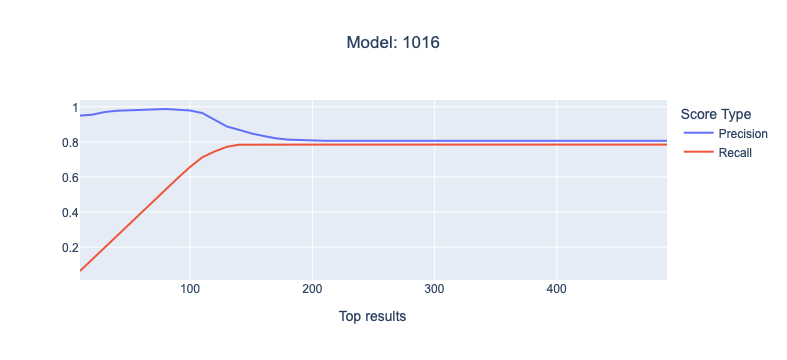

In [68]:
for topic_no in topic_numbers:
    precision_list = precision_dictionary[topic_no]
    recall_list = recall_dictionary[topic_no]
    plot_pr_metrics(top_n,precision_list,recall_list,'Model: ' + str(topic_no))

[20, 936, 946, 956, 966, 972, 973, 974, 975, 976, 20, 936, 946, 956, 966, 972, 973, 974, 975]


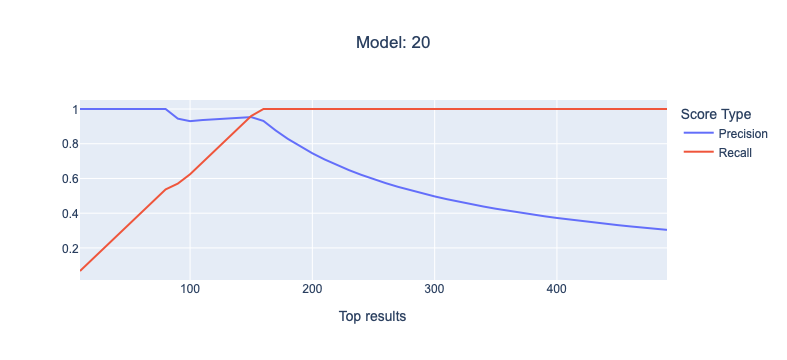

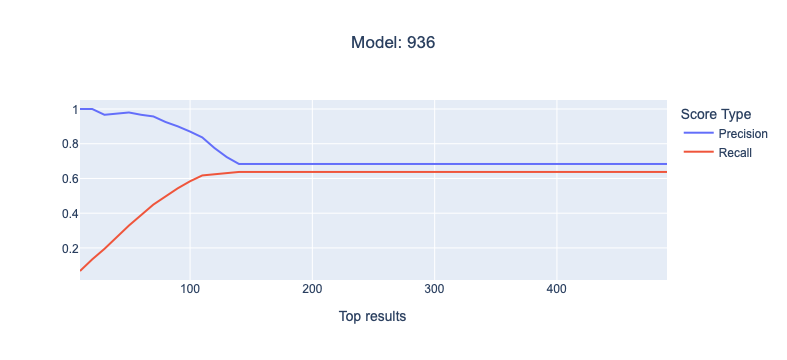

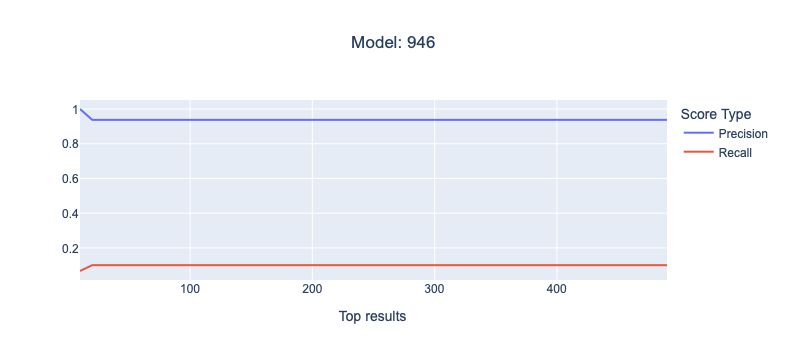

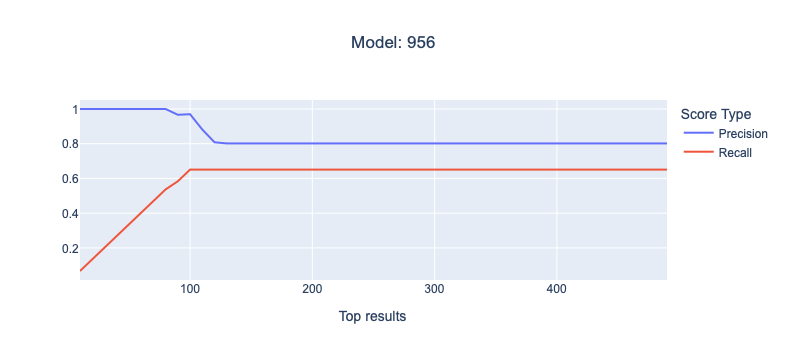

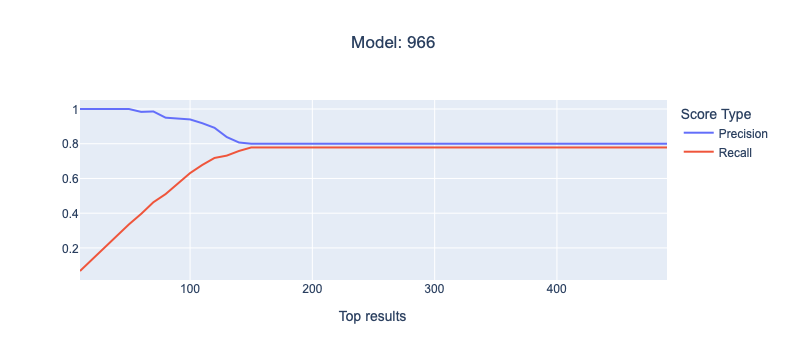

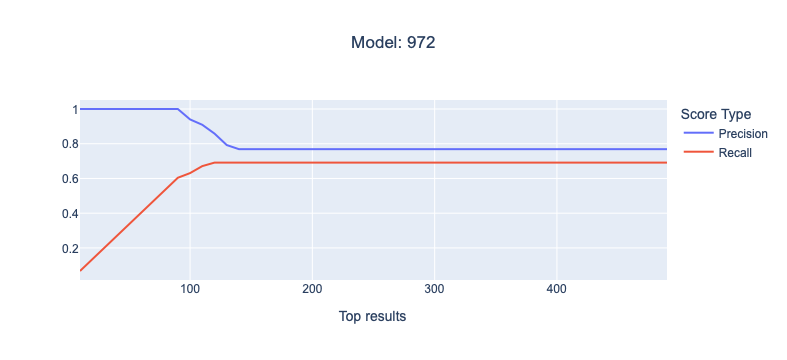

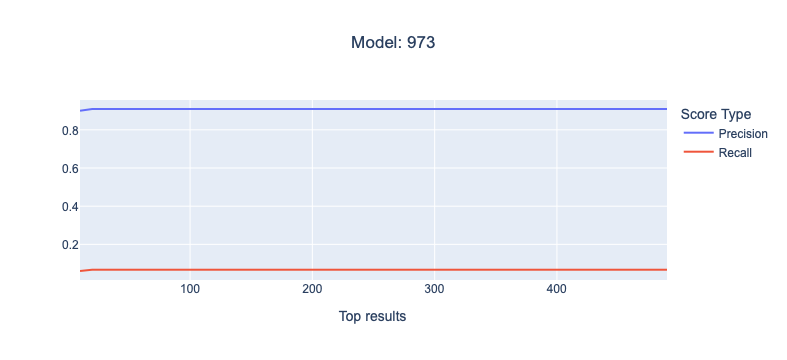

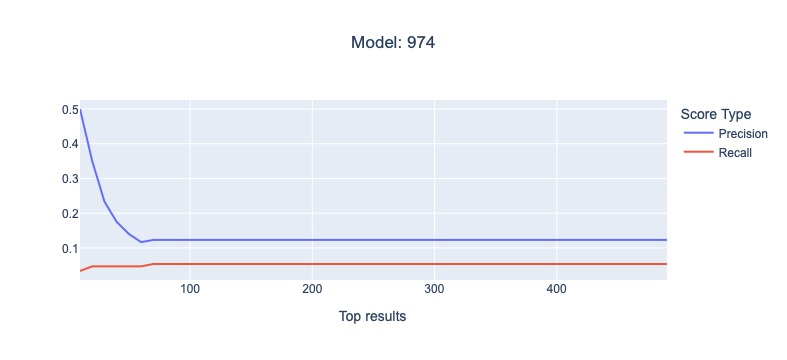

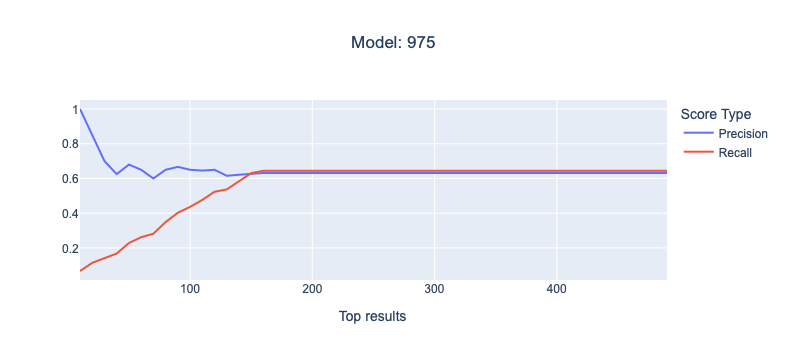

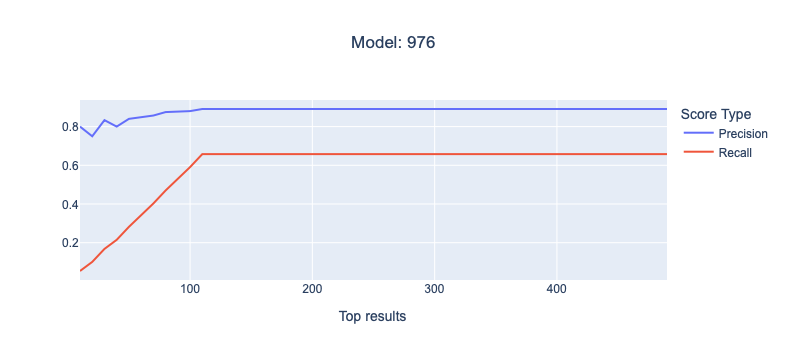

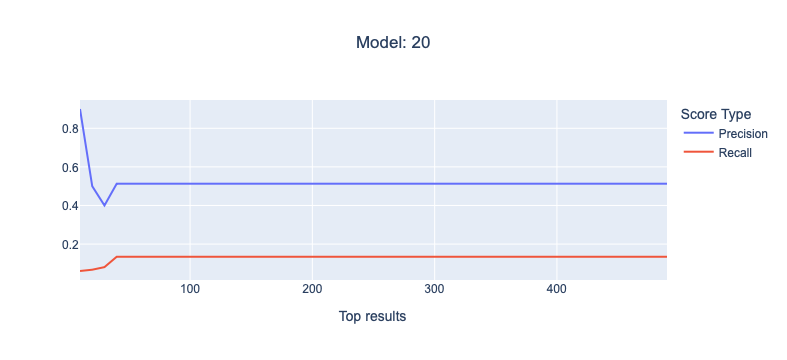

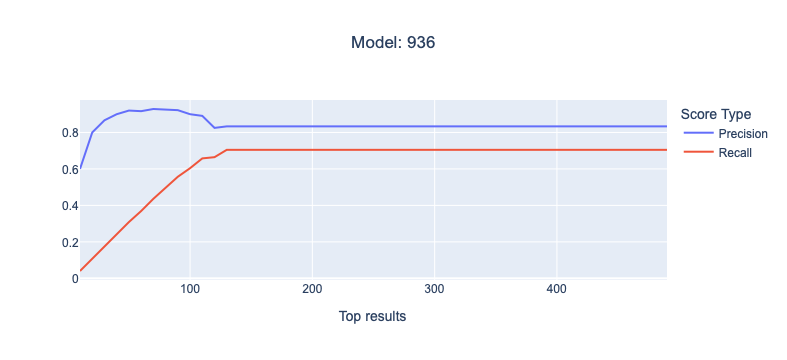

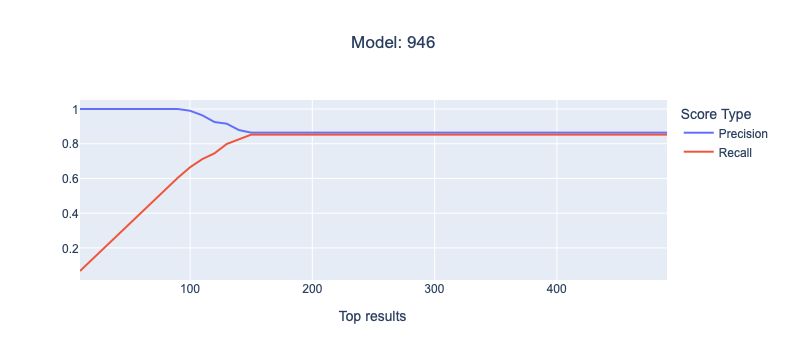

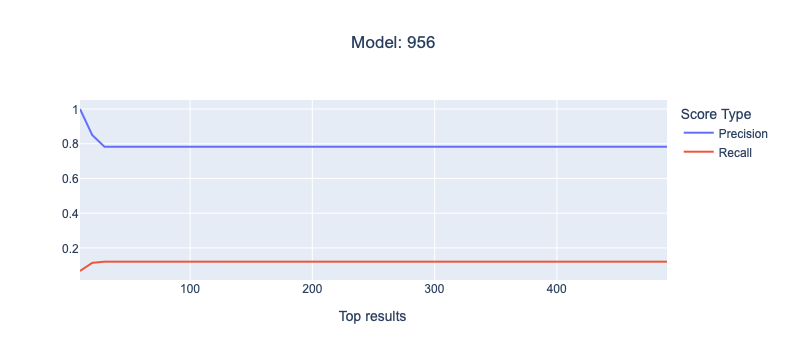

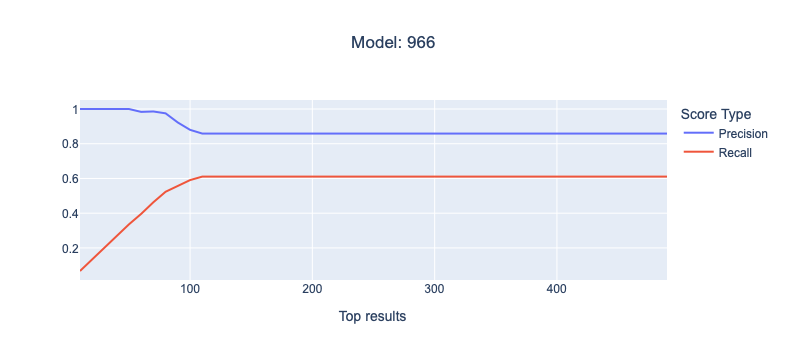

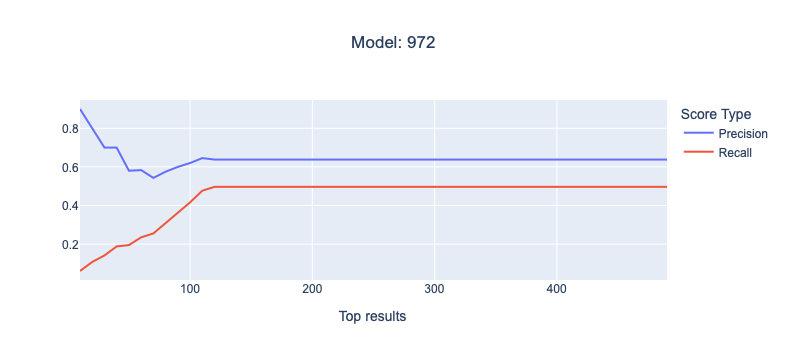

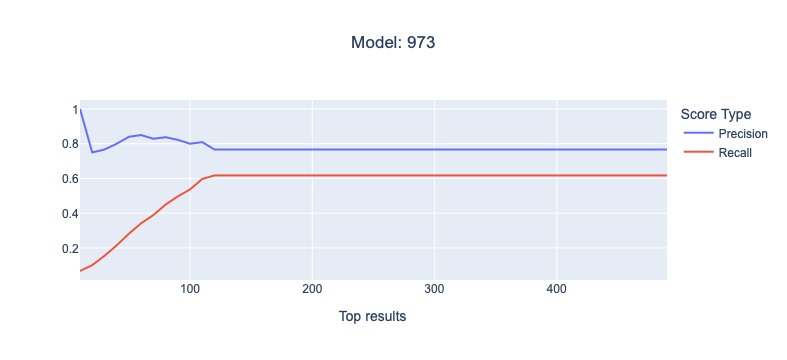

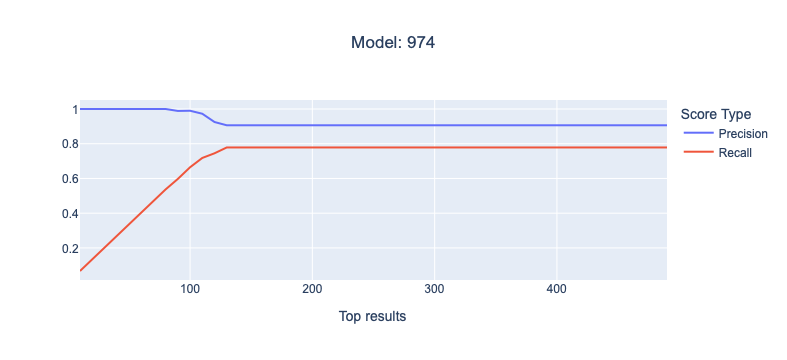

In [40]:
#total_revelant = 149
#top_n = [10,20,30,50,5000]
top_n = [x*10 for x in range(1, 50)]

topic_numbers = num_topics_list_lower + [reference_nr_topics] + num_topics_list_upper
#print(topic_numbers)


for model_nr in range(0,18):
    ranked_emails = ranked_email_list[model_nr]
    file_mapping = file_mapping_list[model_nr]
    precision_list,recall_list = generate_metrics(ranked_emails, file_mapping, top_n)
    plot_pr_metrics(top_n,precision_list,recall_list,'Model: ' + str(topic_numbers[model_nr]))



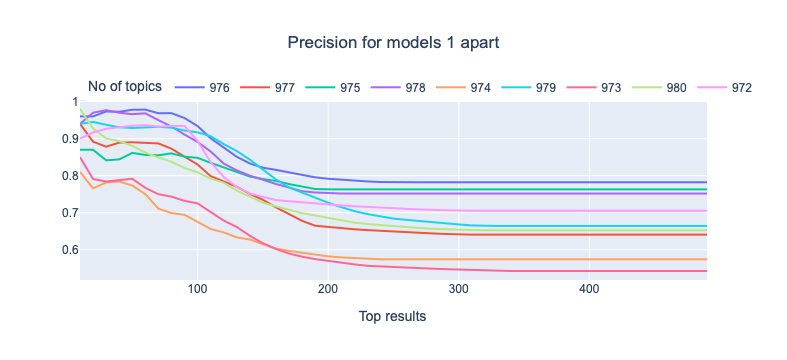

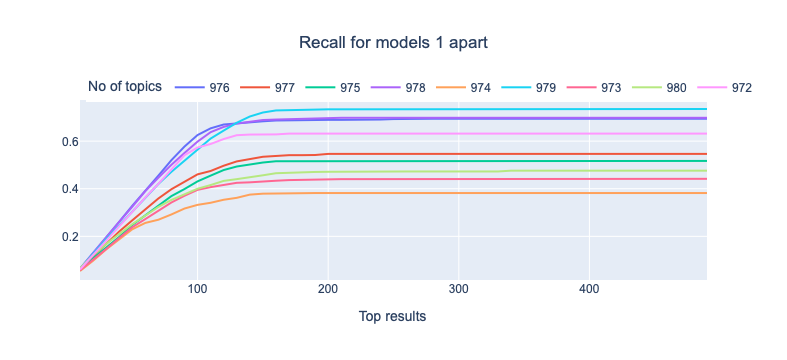

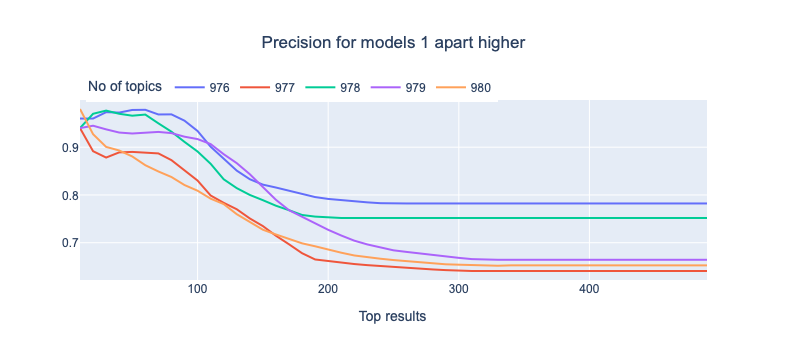

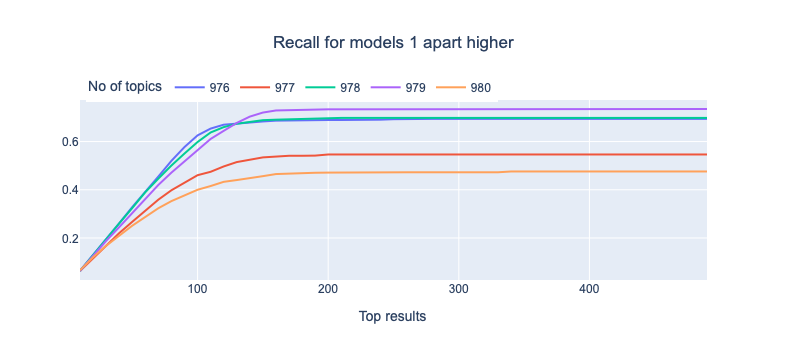

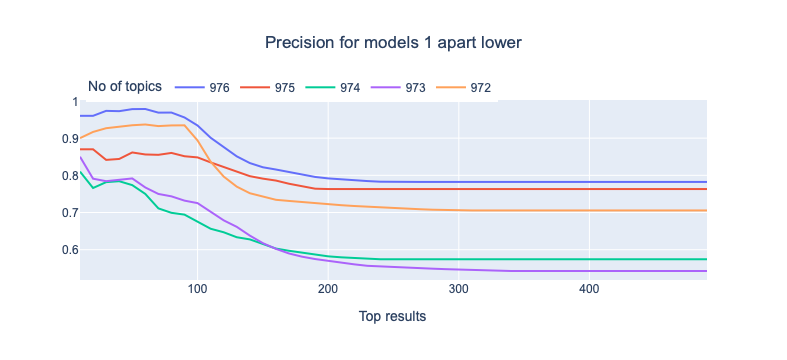

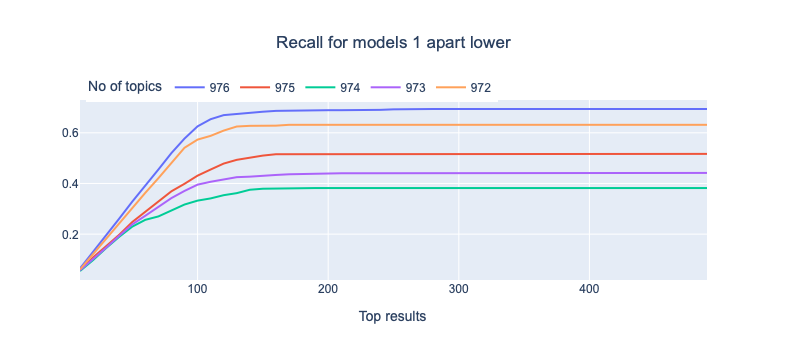

In [51]:
legend_title = "No of topics"


# Build the lists for 1 apart for all
name_list = []
precision_list = []
recall_list = []

name_list.append(str(reference_nr_topics))
precision_list.append(precision_dictionary[reference_nr_topics])
recall_list.append(recall_dictionary[reference_nr_topics])
for count in range(1,5):
    name_list.append(str(reference_nr_topics+count))
    name_list.append(str(reference_nr_topics-count))
    precision_list.append(precision_dictionary[reference_nr_topics+count])
    precision_list.append(precision_dictionary[reference_nr_topics-count])
    recall_list.append(recall_dictionary[reference_nr_topics+count])
    recall_list.append(recall_dictionary[reference_nr_topics-count])



title = "Precision for models 1 apart"
plot_multiple_metrics(top_n, name_list, precision_list, title, legend_title)

title = "Recall for models 1 apart"
plot_multiple_metrics(top_n, name_list, recall_list, title, legend_title)



# Build the lists for 1 apart higher than reference

name_list = []
precision_list = []
recall_list = []

name_list.append(str(reference_nr_topics))
precision_list.append(precision_dictionary[reference_nr_topics])
recall_list.append(recall_dictionary[reference_nr_topics])
for count in range(1,5):
    name_list.append(str(reference_nr_topics+count))
    precision_list.append(precision_dictionary[reference_nr_topics+count])
    recall_list.append(recall_dictionary[reference_nr_topics+count])


title = "Precision for models 1 apart higher"
plot_multiple_metrics(top_n, name_list, precision_list, title, legend_title)

title = "Recall for models 1 apart higher"
plot_multiple_metrics(top_n, name_list, recall_list, title, legend_title)




# Build the lists for 1 apart lower than reference
name_list = []
precision_list = []
recall_list = []

name_list.append(str(reference_nr_topics))
precision_list.append(precision_dictionary[reference_nr_topics])
recall_list.append(recall_dictionary[reference_nr_topics])
for count in range(1,5):
    name_list.append(str(reference_nr_topics-count))
    precision_list.append(precision_dictionary[reference_nr_topics-count])
    recall_list.append(recall_dictionary[reference_nr_topics-count])


title = "Precision for models 1 apart lower"
plot_multiple_metrics(top_n, name_list, precision_list, title, legend_title)

title = "Recall for models 1 apart lower"
plot_multiple_metrics(top_n, name_list, recall_list, title, legend_title)







['976', '986', '966', '996', '956', '1006', '946', '1016', '936', '20']


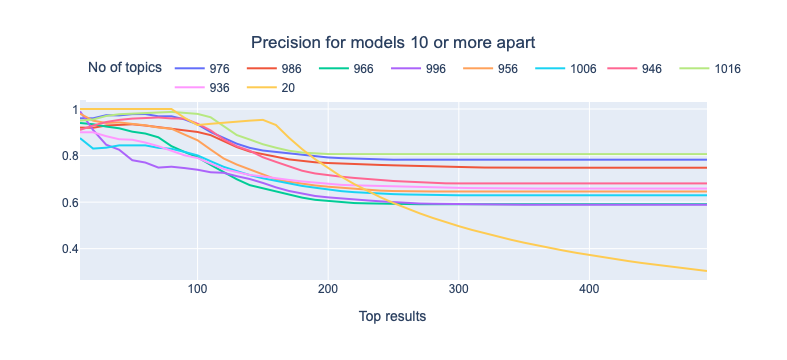

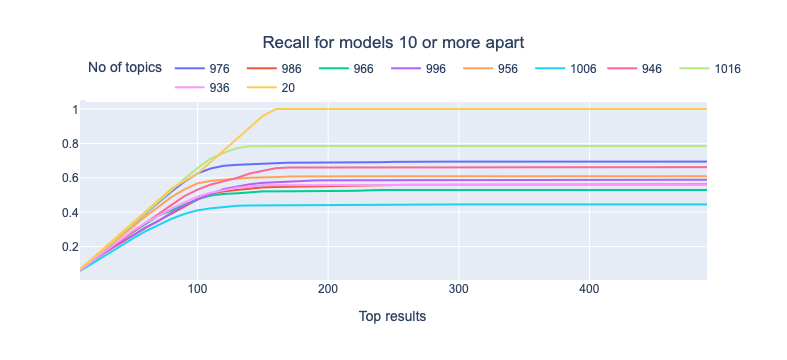

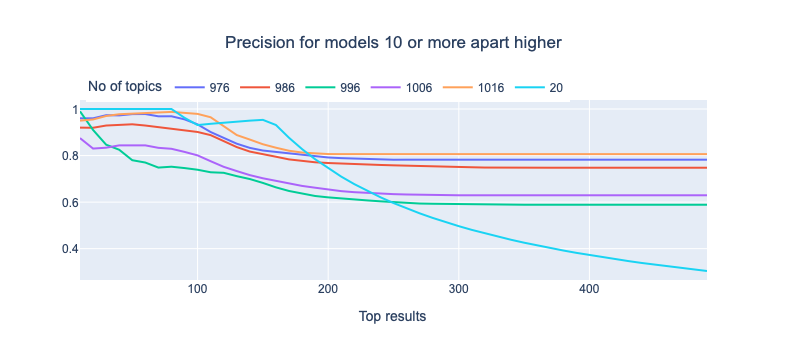

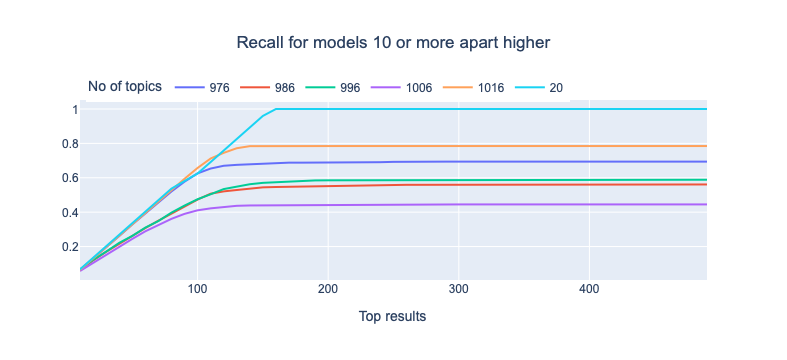

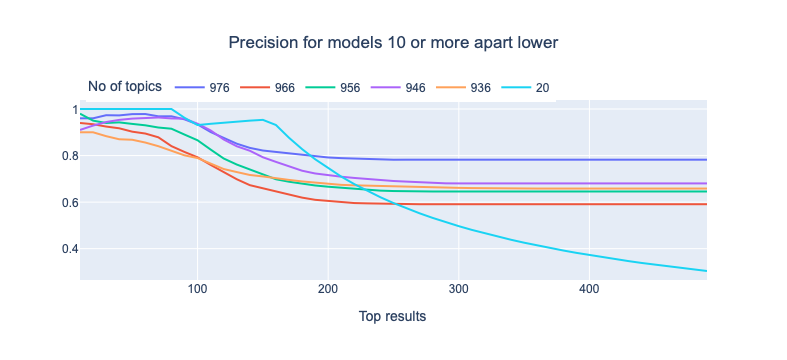

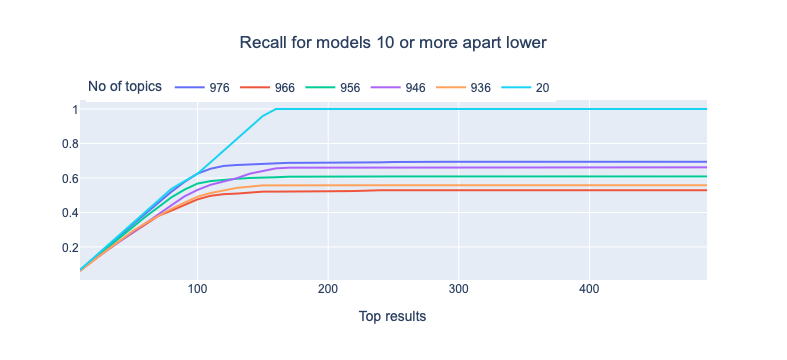

In [52]:
legend_title = "No of topics"


def plot_multiple_metrics(top_n, name_list, metric_list, title, legend_title):
    fig = go.Figure()
    for name,metric in zip(name_list,metric_list):
        fig.add_scatter(x=top_n, y=metric, name=name)
    
    fig.update_layout(
    title={
        'text' : title,
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title={
        'text' : "Top results"
        },
    yaxis_title="",
    #legend_title=legend_title,
    legend=dict(
        title=legend_title,
        yanchor="bottom",
        y=0.99,
        xanchor="left",
        x=0.01,
        orientation="h"),
#    yaxis_range=[0,1.1],
    font=dict(
        family="Arial"
        )
    )
    fig.show()

# Build the lists for 1 apart for all
name_list = []
precision_list = []
recall_list = []

name_list.append(str(reference_nr_topics))
precision_list.append(precision_dictionary[reference_nr_topics])
recall_list.append(recall_dictionary[reference_nr_topics])
for count in range(10,50,10):
    name_list.append(str(reference_nr_topics+count))
    name_list.append(str(reference_nr_topics-count))
    precision_list.append(precision_dictionary[reference_nr_topics+count])
    precision_list.append(precision_dictionary[reference_nr_topics-count])
    recall_list.append(recall_dictionary[reference_nr_topics+count])
    recall_list.append(recall_dictionary[reference_nr_topics-count])
name_list.append("20")
precision_list.append(precision_dictionary[20])
recall_list.append(recall_dictionary[20])
print(name_list)





title = "Precision for models 10 or more apart"
plot_multiple_metrics(top_n, name_list, precision_list, title, legend_title)

title = "Recall for models 10 or more apart"
plot_multiple_metrics(top_n, name_list, recall_list, title, legend_title)



# Build the lists for 1 apart higher than reference

name_list = []
precision_list = []
recall_list = []

name_list.append(str(reference_nr_topics))
precision_list.append(precision_dictionary[reference_nr_topics])
recall_list.append(recall_dictionary[reference_nr_topics])
for count in range(10,50,10):
    name_list.append(str(reference_nr_topics+count))
    precision_list.append(precision_dictionary[reference_nr_topics+count])
    recall_list.append(recall_dictionary[reference_nr_topics+count])
name_list.append("20")
precision_list.append(precision_dictionary[20])
recall_list.append(recall_dictionary[20])


title = "Precision for models 10 or more apart higher"
plot_multiple_metrics(top_n, name_list, precision_list, title, legend_title)

title = "Recall for models 10 or more apart higher"
plot_multiple_metrics(top_n, name_list, recall_list, title, legend_title)




# Build the lists for 10 apart lower than reference
name_list = []
precision_list = []
recall_list = []

name_list.append(str(reference_nr_topics))
precision_list.append(precision_dictionary[reference_nr_topics])
recall_list.append(recall_dictionary[reference_nr_topics])
for count in range(10,50,10):
    name_list.append(str(reference_nr_topics-count))
    precision_list.append(precision_dictionary[reference_nr_topics-count])
    recall_list.append(recall_dictionary[reference_nr_topics-count])
name_list.append("20")
precision_list.append(precision_dictionary[20])
recall_list.append(recall_dictionary[20])



title = "Precision for models 10 or more apart lower"
plot_multiple_metrics(top_n, name_list, precision_list, title, legend_title)

title = "Recall for models 10 or more apart lower"
plot_multiple_metrics(top_n, name_list, recall_list, title, legend_title)



In [8]:
# Store the internal state for the multiple queries
import pickle

print('Storing the precision dictionary')
with open('./stored_state_experiment2/precision_dictionary.dat', 'wb') as filehandle:
    pickle.dump(precision_dictionary, filehandle)

print('Storing the recall dictionary')
with open('./stored_state_experiment2/recall_dictionary.dat', 'wb') as filehandle:
    pickle.dump(recall_dictionary, filehandle)

print('Internal state stored.')

Storing the precision dictionary
Storing the recall dictionary
Internal state stored.


In [10]:
import pickle

with open('./stored_state_experiment2/precision_dictionary.dat', 'rb') as filehandle:
    # read the data as binary data stream
    precision_dictionary = pickle.load(filehandle)
    
with open('./stored_state_experiment2/recall_dictionary.dat', 'rb') as filehandle:
    # read the data as binary data stream
    recall_dictionary = pickle.load(filehandle)

reference_nr_topics = 976
top_n = [x*10 for x in range(1, 50)]